# Libraries and Data Import
Also have a quick look at the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
repository_directory = "../"
construct_df_hd_model = True

In [2]:
df_source = pd.read_csv(repository_directory + "data/data_Q1_2021/2021-01-01.csv", parse_dates=["date"])
df_source.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2021-01-01,ZLW0EGC6,ST12000NM001G,12000138625024,0,83.0,213166608.0,NaN,NaN,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01,Z305B2QN,ST4000DM000,4000787030016,0,114.0,79306032.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01,ZLW0C6NE,ST12000NM001G,12000138625024,0,72.0,17162816.0,NaN,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-01,ZJV0XJQ3,ST12000NM0007,12000138625024,0,100.0,1102160.0,NaN,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-01,ZLW18MKT,ST14000NM001G,14000519643136,0,75.0,33233248.0,NaN,NaN,95.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df_source.iloc[:,:10].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165512 entries, 0 to 165511
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date                165512 non-null  datetime64[ns]
 1   serial_number       165512 non-null  object        
 2   model               165512 non-null  object        
 3   capacity_bytes      165512 non-null  int64         
 4   failure             165512 non-null  int64         
 5   smart_1_normalized  165394 non-null  float64       
 6   smart_1_raw         165394 non-null  float64       
 7   smart_2_normalized  62489 non-null   float64       
 8   smart_2_raw         62489 non-null   float64       
 9   smart_3_normalized  164256 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(2)
memory usage: 12.6+ MB


In [4]:
df_source.nunique()

date                         1
serial_number           165512
model                       59
capacity_bytes              15
failure                      2
                         ...  
smart_252_raw                0
smart_254_normalized         2
smart_254_raw                1
smart_255_normalized         0
smart_255_raw                0
Length: 149, dtype: int64

In [5]:
df_source.groupby("failure").count()["serial_number"]

failure
0    165508
1         4
Name: serial_number, dtype: int64

# Some Useful Functions and Lists

In [6]:
# specify commonly used column names
column_name_all = df_source.columns
column_name_basic, column_name_smart = column_name_all[:5], column_name_all[5:]
column_name_smart_raw = pd.Index([c for c in column_name_smart if "raw" in c ])
column_name_smart_normalized = pd.Index([c for c in column_name_smart if "normalized" in c ])

# collections of important smart parameters from different sources
key_smart_backblaze = [5, 187, 188, 197, 198] # https://www.backblaze.com/blog/what-smart-stats-indicate-hard-drive-failures/
key_smart_wiki = [5, 10, 184, 187, 188, 196, 197, 198, 201] # https://en.wikipedia.org/wiki/S.M.A.R.T.
key_smart_ai_paper = [3, 5, 7, 187, 188, 190, 197, 198] # https://www.sciencedirect.com/science/article/pii/S2666827021000219
key_smart_power_on_time = [9]
key_smart_group = [5, 183, 184, 187]

# choose smart and set up the column name 
key_smart = [5, 183, 184, 187]
column_name = pd.Index(list(column_name_basic) + ["smart_" + str(i) + "_" + "raw" for i in key_smart])
print(column_name)

def smart2meaningful(col):
    """smart to meaningful names
    see wiki for more info: https://en.wikipedia.org/wiki/S.M.A.R.T.

    Args:
        col (panda.Index): name of columns returned from a dataframe

    Returns:
        panda.Index: a column with more meaningful names
    """
    dict_smart = {3   : "spin_up_time",
                  5   : "reallocated_sector_count", # or "bad-sector count" 
                  7   : "seek_error_rate", # or "reading-head seek-error rate", vendor-dependent
                  9   : "power_on_time", 
                  10  : "spin_retry_count",
                  183 : "downshift_error_count", #  another possible meaning is: Runtime Bad Block
                  184 : "end_to_end_error", # vendor-dependent
                  187 : "reported_uncorrectable_error",
                  188 : "command_timeout_count",
                  190 : "temperature_special", # vendor-dependent
                  194 : "temperature",
                  196 : "reallocation_event_count",
                  197 : "current_pending_sector_count", # or "unusable sector count"
                  198 : "uncorrectable_sector_count", 
                  201 : "software_read_error_count", 
                  231 : "expected_life_left"
    }
    col_modified = []
    for name in list(col):
        if "smart_" in name:
            number = int(name.split("smart_")[1].split("_")[0])
            if number in list(dict_smart.keys()):
                col_modified.append(name.replace("smart_" + str(number), dict_smart[number]))
            else:
                col_modified.append(name)
        else:
            col_modified.append(name)
    return pd.Index(col_modified)

# change the smart name into meaningful names for a dataframe
# this should be applied only after you perform all operations on columns
def smart2meaningful_for_dataframe(df):
    df.columns = smart2meaningful(df.columns)
    return df

# drop all smart columns except those specified by smart_to_keep
def keep_some_smart_column_for_dataframe(df, smart_to_keep=[], raw_or_normalized="raw"):
    cols = df.columns
    cols_nonsmart = [col for col in cols if not "smart_" in col]
    #cols_smart = [col for col in cols if "smart_" in col]
    #s = set(cols_smart)
    cols_smart = ["smart_" + str(i) + "_" + raw_or_normalized for i in smart_to_keep]
    return df[cols_nonsmart + cols_smart]

def change_feature_dtype_for_dataframe(df, feature_to_change=[]):
    col = df.columns
    for feature in feature_to_change:
        if not feature in col:
            print("### Error!")
            print(f"### The feature '{feature}' is not found in the dataframe '{df}'!")
            print("### Partially modified dataframe is returned!")
            return df
        if feature == "failure":
            df.astype({feature : "int64"})
        elif feature == "date":
            df[feature] = pd.to_datetime(df[feature], format='%Y-%m-%d')
    return df

# create features for a dataframe
def create_features_for_dataframe(df, features_to_create=[], drop=False):
    feature_to_drop = []
    col = df.columns
    for feature in features_to_create:
        if feature == "capacity_gb":
            features_needed = ["capacity_bytes"]
            for feature_needed in features_needed:
                if not feature_needed in col:
                    print("### Error!")
                    print(f"### Cannot create '{feature}' because the required feature '{feature_needed}' is not found in the dataframe '{df}'!")
                    print("### Partially modified dataframe is returned!")
                    return df
            gb2byte = 1024**3
            df[feature] = df[features_needed[0]].apply(lambda x : int(x)/gb2byte)
            feature_to_drop.append(*features_needed)
        #elif feature == "power_on_time_day":
        #    df[feature] = df["power_on_time"].apply(lambda x : x/24)
        #    feature_to_drop.append("power_on_time")
    if drop:
        df.drop(list(set(feature_to_drop)), axis=1, inplace=True)
    return df

Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_5_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw'],
      dtype='object')


# EDA (one day)

In [7]:
df = pd.read_csv(repository_directory + "data/data_Q1_2021/2021-01-01.csv")

In [8]:
df = change_feature_dtype_for_dataframe(df, feature_to_change=["date"])
df = keep_some_smart_column_for_dataframe(df, smart_to_keep=key_smart, raw_or_normalized="raw")
df = create_features_for_dataframe(df, features_to_create=["capacity_gb"], drop=True)
df = smart2meaningful_for_dataframe(df)

In [9]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165512 entries, 0 to 165511
Data columns (total 9 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   date                              165512 non-null  datetime64[ns]
 1   serial_number                     165512 non-null  object        
 2   model                             165512 non-null  object        
 3   failure                           165512 non-null  int64         
 4   reallocated_sector_count_raw      164300 non-null  float64       
 5   downshift_error_count_raw         19866 non-null   float64       
 6   end_to_end_error_raw              45551 non-null   float64       
 7   reported_uncorrectable_error_raw  101503 non-null  float64       
 8   capacity_gb                       165512 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 11.4+ MB


There isn't many failed disk to see in a data of just one day:

In [10]:

df.groupby("failure").count()["serial_number"]


failure
0    165508
1         4
Name: serial_number, dtype: int64

# EDA (one hd model over three months)

In [11]:
# check the top 10  most frequent model
pd.unique(df["model"])
df.groupby("model").count().sort_values(by="serial_number", ascending=False).head(10)


,date,serial_number,failure,reallocated_sector_count_raw,downshift_error_count_raw,end_to_end_error_raw,reported_uncorrectable_error_raw,capacity_gb
model,,,,,,,,
ST12000NM0007,23036,23036,23036,23036,0,0,23036,23036
TOSHIBA MG07ACA14TA,21027,21027,21027,21027,0,0,0,21027
ST12000NM0008,19287,19287,19287,19287,0,0,19287,19287
ST4000DM000,18939,18939,18939,18939,18939,18939,18939,18939
ST8000NM0055,14406,14406,14406,14406,0,14406,14406,14406
HGST HMS5C4040BLE640,12744,12744,12744,12744,0,0,0,12744
HGST HUH721212ALN604,10830,10830,10830,10830,0,0,0,10830
ST8000DM002,9770,9770,9770,9770,0,9770,9770,9770
ST12000NM001G,7130,7130,7130,7128,0,0,7128,7130


In [12]:
# select the model and observe its basics
hd_model = "ST4000DM000"
df.query("model == @hd_model").info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18939 entries, 1 to 165490
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   date                              18939 non-null  datetime64[ns]
 1   serial_number                     18939 non-null  object        
 2   model                             18939 non-null  object        
 3   failure                           18939 non-null  int64         
 4   reallocated_sector_count_raw      18939 non-null  float64       
 5   downshift_error_count_raw         18939 non-null  float64       
 6   end_to_end_error_raw              18939 non-null  float64       
 7   reported_uncorrectable_error_raw  18939 non-null  float64       
 8   capacity_gb                       18939 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 1.4+ MB


In [13]:
# reading data from a given period
start_date = "2021-01-01"
end_date = "2021-03-31"
directory_quarter = "data_Q1_2021/"
days = pd.Period(end_date).dayofyear - pd.Period(start_date).dayofyear + 1

# create a list of empty dataframes for concatenation later
#df_hd_model = pd.DataFrame([], columns=df_source.columns)

print(f"Construct the data frame for the model: {hd_model}")
print(f"Read files from {start_date} to {end_date}; totally {days} days")
if construct_df_hd_model:
#if False:
    for day in range(days):
        date = pd.Period(start_date) + day
        print(f"  reading data for the date {date}; progress: {day+1}/{days}")
        file_path = repository_directory + "data/" + directory_quarter + str(date) + ".csv"
        df_tmp = pd.read_csv(file_path)#, parse_dates=["date"])
        if day == 0:
            df_hd_model = df_tmp.copy().query("model == @hd_model")
        else:
            #df_tmp = df_tmp[column_name]
            df_hd_model = pd.concat([df_hd_model, df_tmp.query("model == @hd_model")], ignore_index=True)

    df_hd_model = df_hd_model[column_name]

Construct the data frame for the model: ST4000DM000
Read files from 2021-01-01 to 2021-03-31; totally 90 days
  reading data for the date 2021-01-01; progress: 1/90
  reading data for the date 2021-01-02; progress: 2/90
  reading data for the date 2021-01-03; progress: 3/90
  reading data for the date 2021-01-04; progress: 4/90
  reading data for the date 2021-01-05; progress: 5/90
  reading data for the date 2021-01-06; progress: 6/90
  reading data for the date 2021-01-07; progress: 7/90
  reading data for the date 2021-01-08; progress: 8/90
  reading data for the date 2021-01-09; progress: 9/90
  reading data for the date 2021-01-10; progress: 10/90
  reading data for the date 2021-01-11; progress: 11/90
  reading data for the date 2021-01-12; progress: 12/90
  reading data for the date 2021-01-13; progress: 13/90
  reading data for the date 2021-01-14; progress: 14/90
  reading data for the date 2021-01-15; progress: 15/90
  reading data for the date 2021-01-16; progress: 16/90
  r

In [14]:
df_hd_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1701967 entries, 0 to 1701966
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   serial_number   object 
 2   model           object 
 3   capacity_bytes  int64  
 4   failure         int64  
 5   smart_5_raw     float64
 6   smart_183_raw   float64
 7   smart_184_raw   float64
 8   smart_187_raw   float64
dtypes: float64(4), int64(2), object(3)
memory usage: 116.9+ MB


In [15]:
if construct_df_hd_model:
    df_hd_model = change_feature_dtype_for_dataframe(df_hd_model, feature_to_change=["date", "failure"])
    df_hd_model = keep_some_smart_column_for_dataframe(df_hd_model, smart_to_keep=key_smart, raw_or_normalized="raw")
    #df_hd_model = create_features_for_dataframe(df_hd_model, features_to_create=["capacity_gb"], drop=True)
    df_hd_model = smart2meaningful_for_dataframe(df_hd_model)

In [16]:
df_hd_model.head()

,date,serial_number,model,capacity_bytes,failure,reallocated_sector_count_raw,downshift_error_count_raw,end_to_end_error_raw,reported_uncorrectable_error_raw
0,2021-01-01,Z305B2QN,ST4000DM000,4000787030016,0,0.0,0.0,0.0,0.0
1,2021-01-01,Z305DEMG,ST4000DM000,4000787030016,0,0.0,0.0,0.0,0.0
2,2021-01-01,Z305DEMX,ST4000DM000,4000787030016,0,0.0,0.0,0.0,0.0
3,2021-01-01,Z305D6ZM,ST4000DM000,4000787030016,0,0.0,2.0,0.0,31.0
4,2021-01-01,S301NGZV,ST4000DM000,4000787030016,0,0.0,2.0,0.0,0.0


In [17]:
df_hd_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1701967 entries, 0 to 1701966
Data columns (total 9 columns):
 #   Column                            Dtype         
---  ------                            -----         
 0   date                              datetime64[ns]
 1   serial_number                     object        
 2   model                             object        
 3   capacity_bytes                    int64         
 4   failure                           int64         
 5   reallocated_sector_count_raw      float64       
 6   downshift_error_count_raw         float64       
 7   end_to_end_error_raw              float64       
 8   reported_uncorrectable_error_raw  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 116.9+ MB


In [18]:
# handling nan
df_hd_model.isnull().sum(axis=0)

date                                  0
serial_number                         0
model                                 0
capacity_bytes                        0
failure                               0
reallocated_sector_count_raw        104
downshift_error_count_raw           104
end_to_end_error_raw                104
reported_uncorrectable_error_raw    104
dtype: int64

We simply drop nan here because they only take a small portion of the whole data.

In [19]:
df_hd_model.dropna(inplace=True)

In [20]:
if construct_df_hd_model:
    print("Save dataframe to csv files")
    file_path = repository_directory + "data/hd_model_" + hd_model + "_from_" + start_date + "_to_" + end_date + ".csv" 
    df_hd_model.to_csv(file_path, index=False)
    print(f"Dataframe is saved successfully at  \"{file_path}\"")

Save dataframe to csv files
Dataframe is saved successfully at  "../data/hd_model_ST4000DM000_from_2021-01-01_to_2021-03-31.csv"


In [21]:
# read the csv file 
file_path = repository_directory + "data/hd_model_" + hd_model + "_from_" + start_date + "_to_" + end_date + ".csv" 
print(file_path)
df_hd_model = pd.read_csv(file_path, parse_dates=["date"])
df_hd_model.head()

../data/hd_model_ST4000DM000_from_2021-01-01_to_2021-03-31.csv


,date,serial_number,model,capacity_bytes,failure,reallocated_sector_count_raw,downshift_error_count_raw,end_to_end_error_raw,reported_uncorrectable_error_raw
0,2021-01-01,Z305B2QN,ST4000DM000,4000787030016,0,0.0,0.0,0.0,0.0
1,2021-01-01,Z305DEMG,ST4000DM000,4000787030016,0,0.0,0.0,0.0,0.0
2,2021-01-01,Z305DEMX,ST4000DM000,4000787030016,0,0.0,0.0,0.0,0.0
3,2021-01-01,Z305D6ZM,ST4000DM000,4000787030016,0,0.0,2.0,0.0,31.0
4,2021-01-01,S301NGZV,ST4000DM000,4000787030016,0,0.0,2.0,0.0,0.0


In [22]:
df_hd_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1701863 entries, 0 to 1701862
Data columns (total 9 columns):
 #   Column                            Dtype         
---  ------                            -----         
 0   date                              datetime64[ns]
 1   serial_number                     object        
 2   model                             object        
 3   capacity_bytes                    int64         
 4   failure                           int64         
 5   reallocated_sector_count_raw      float64       
 6   downshift_error_count_raw         float64       
 7   end_to_end_error_raw              float64       
 8   reported_uncorrectable_error_raw  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 116.9+ MB


In [118]:
df_hd_model.nunique()

date                                     90
serial_number                         18941
model                                     1
failure                                   2
spin_up_time_raw                          1
reallocated_sector_count_raw            503
seek_error_rate_raw                 1700098
power_on_time_raw                     24450
reported_uncorrectable_error_raw        270
command_timeout_count_raw                26
current_pending_sector_count_raw        171
uncorrectable_sector_count_raw          171
capacity_gb                               1
dtype: int64

In [23]:
# failed hd
df_hd_model_failure = df_hd_model.query("failure == 1")
df_hd_model_failure.nunique()

date                                43
serial_number                       59
model                                1
capacity_bytes                       1
failure                              1
reallocated_sector_count_raw        22
downshift_error_count_raw           14
end_to_end_error_raw                 8
reported_uncorrectable_error_raw    35
dtype: int64

In [34]:
df_hd_model_failure.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59 entries, 25917 to 1663467
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   date                              59 non-null     datetime64[ns]
 1   serial_number                     59 non-null     object        
 2   model                             59 non-null     object        
 3   capacity_bytes                    59 non-null     int64         
 4   failure                           59 non-null     int64         
 5   reallocated_sector_count_raw      59 non-null     float64       
 6   downshift_error_count_raw         59 non-null     float64       
 7   end_to_end_error_raw              59 non-null     float64       
 8   reported_uncorrectable_error_raw  59 non-null     float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 4.6+ KB


In [26]:
df_hd_model.head(5)

,date,serial_number,model,capacity_bytes,failure,reallocated_sector_count_raw,downshift_error_count_raw,end_to_end_error_raw,reported_uncorrectable_error_raw
0,2021-01-01,Z305B2QN,ST4000DM000,4000787030016,0,0.0,0.0,0.0,0.0
1,2021-01-01,Z305DEMG,ST4000DM000,4000787030016,0,0.0,0.0,0.0,0.0
2,2021-01-01,Z305DEMX,ST4000DM000,4000787030016,0,0.0,0.0,0.0,0.0
3,2021-01-01,Z305D6ZM,ST4000DM000,4000787030016,0,0.0,2.0,0.0,31.0
4,2021-01-01,S301NGZV,ST4000DM000,4000787030016,0,0.0,2.0,0.0,0.0


In [27]:
df_hd_model["count_down"] = np.nan
df_hd_model["day_of_failure"] = pd.Timestamp('2021-02-28')
df_hd_model["failure_eventually"] = False
for serial in df_hd_model_failure["serial_number"]:
    df_hd_model.loc[df_hd_model["serial_number"]==serial, "day_of_failure"] = pd.Timestamp(df_hd_model_failure.query("serial_number == @serial")["date"].iloc[0])
    df_hd_model.loc[df_hd_model["serial_number"]==serial, "failure_eventually"] = True


In [28]:
df_hd_model["count_down"] = df_hd_model["day_of_failure"].dt.day - df_hd_model["date"].dt.day
df_hd_model.head(5)

,date,serial_number,model,capacity_bytes,failure,reallocated_sector_count_raw,downshift_error_count_raw,end_to_end_error_raw,reported_uncorrectable_error_raw,count_down,day_of_failure,failure_eventually
0,2021-01-01,Z305B2QN,ST4000DM000,4000787030016,0,0.0,0.0,0.0,0.0,27,2021-02-28,False
1,2021-01-01,Z305DEMG,ST4000DM000,4000787030016,0,0.0,0.0,0.0,0.0,27,2021-02-28,False
2,2021-01-01,Z305DEMX,ST4000DM000,4000787030016,0,0.0,0.0,0.0,0.0,27,2021-02-28,False
3,2021-01-01,Z305D6ZM,ST4000DM000,4000787030016,0,0.0,2.0,0.0,31.0,27,2021-02-28,False
4,2021-01-01,S301NGZV,ST4000DM000,4000787030016,0,0.0,2.0,0.0,0.0,27,2021-02-28,False


In [29]:
df_hd_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1701863 entries, 0 to 1701862
Data columns (total 12 columns):
 #   Column                            Dtype         
---  ------                            -----         
 0   date                              datetime64[ns]
 1   serial_number                     object        
 2   model                             object        
 3   capacity_bytes                    int64         
 4   failure                           int64         
 5   reallocated_sector_count_raw      float64       
 6   downshift_error_count_raw         float64       
 7   end_to_end_error_raw              float64       
 8   reported_uncorrectable_error_raw  float64       
 9   count_down                        int64         
 10  day_of_failure                    datetime64[ns]
 11  failure_eventually                bool          
dtypes: bool(1), datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 144.4+ MB


In [30]:
serial_failure = df_hd_model_failure["serial_number"].to_list()
serial_failure

['S301K7NR',
 'Z302SZMS',
 'Z304K098',
 'Z302T67W',
 'S301GP9K',
 'Z302AKR7',
 'S300Z6HN',
 'Z3059AHR',
 'Z305PJCM',
 'Z305NZY9',
 'S300Z4NB',
 'Z304JGH0',
 'S300Z7MC',
 'S30108TM',
 'Z304JWN9',
 'Z304JW5L',
 'Z304JM6A',
 'Z302SWQX',
 'S301NKK4',
 'Z304KCJ0',
 'Z305D3EY',
 'Z305D22L',
 'S301JH17',
 'Z302T6PW',
 'Z304JWK4',
 'Z302SQVB',
 'Z302SZKW',
 'Z302T7VX',
 'Z302SW4N',
 'Z304QGH9',
 'Z304HKC3',
 'Z304L8A5',
 'S301GQHG',
 'Z305DHWB',
 'S300Z5J1',
 'S3010LZV',
 'Z302B0P9',
 'Z304JG8Q',
 'Z304JCZ2',
 'Z305K29S',
 'Z305FNVM',
 'Z302T7PH',
 'S300Z65Q',
 'Z304T19N',
 'Z305KWFY',
 'Z304JWFE',
 'S3010XYP',
 'S301ECEQ',
 'Z305DTQS',
 'Z305KY0N',
 'Z304JW0E',
 'S301NKXA',
 'S301GLZ6',
 'S301GRZH',
 'Z304JMK9',
 'S301K02H',
 'Z302SY15',
 'Z304JHP2',
 'Z303QQJ7']

In [33]:
#zero_day = pd.Timedelta("0")
df_hd_model.query("count_down < 0 and failure_eventually == True").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 23917 to 1113915
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   date                              712 non-null    datetime64[ns]
 1   serial_number                     712 non-null    object        
 2   model                             712 non-null    object        
 3   capacity_bytes                    712 non-null    int64         
 4   failure                           712 non-null    int64         
 5   reallocated_sector_count_raw      712 non-null    float64       
 6   downshift_error_count_raw         712 non-null    float64       
 7   end_to_end_error_raw              712 non-null    float64       
 8   reported_uncorrectable_error_raw  712 non-null    float64       
 9   count_down                        712 non-null    int64         
 10  day_of_failure                    712 non-

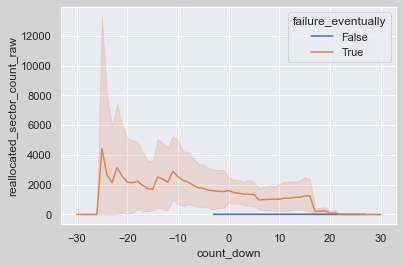

In [219]:
sns.set(rc={'figure.facecolor': "lightgray"})
#ax = sns.lineplot(data=df_hd_model.query("failure_eventually == True"), x="count_down", y="reallocated_sector_count_raw")
#ax = sns.lineplot(data=df_hd_model.query("failure_eventually == False"), x="count_down", y="reallocated_sector_count_raw")
ax = sns.lineplot(data=df_hd_model, x="count_down", y="reallocated_sector_count_raw", hue="failure_eventually")

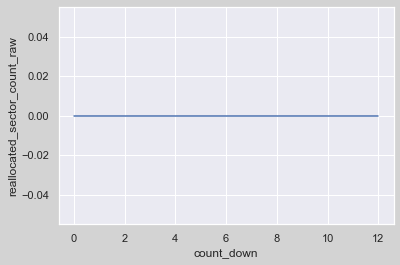

In [220]:
serial = serial_failure[10]
ax = sns.lineplot(data=df_hd_model.query("serial_number == @serial"), x="count_down", y="reallocated_sector_count_raw")

In [221]:
df_hd_model.query("serial_number == @serial")

,date,serial_number,model,failure,spin_up_time_raw,reallocated_sector_count_raw,seek_error_rate_raw,power_on_time_raw,reported_uncorrectable_error_raw,command_timeout_count_raw,current_pending_sector_count_raw,uncorrectable_sector_count_raw,capacity_gb,count_down,day_of_failure,failure_eventually
15465,2021-01-01,S300Z4NB,ST4000DM000,0,0.0,0.0,940532106.0,46975.0,0.0,0.0,0.0,0.0,3726.023277,12,2021-01-13,True
34370,2021-01-02,S300Z4NB,ST4000DM000,0,0.0,0.0,941494961.0,46999.0,0.0,0.0,0.0,0.0,3726.023277,11,2021-01-13,True
53301,2021-01-03,S300Z4NB,ST4000DM000,0,0.0,0.0,943321229.0,47023.0,0.0,0.0,0.0,0.0,3726.023277,10,2021-01-13,True
72237,2021-01-04,S300Z4NB,ST4000DM000,0,0.0,0.0,944541192.0,47047.0,0.0,0.0,0.0,0.0,3726.023277,9,2021-01-13,True
91171,2021-01-05,S300Z4NB,ST4000DM000,0,0.0,0.0,946990591.0,47071.0,0.0,0.0,0.0,0.0,3726.023277,8,2021-01-13,True
110105,2021-01-06,S300Z4NB,ST4000DM000,0,0.0,0.0,948325773.0,47095.0,0.0,0.0,0.0,0.0,3726.023277,7,2021-01-13,True
129043,2021-01-07,S300Z4NB,ST4000DM000,0,0.0,0.0,950255713.0,47119.0,0.0,0.0,0.0,0.0,3726.023277,6,2021-01-13,True
147978,2021-01-08,S300Z4NB,ST4000DM000,0,0.0,0.0,951649854.0,47143.0,0.0,0.0,0.0,0.0,3726.023277,5,2021-01-13,True
166912,2021-01-09,S300Z4NB,ST4000DM000,0,0.0,0.0,953101108.0,47166.0,0.0,0.0,0.0,0.0,3726.023277,4,2021-01-13,True
185846,2021-01-10,S300Z4NB,ST4000DM000,0,0.0,0.0,954831174.0,47190.0,0.0,0.0,0.0,0.0,3726.023277,3,2021-01-13,True


<AxesSubplot:xlabel='count_down', ylabel='reallocated_sector_count_raw'>

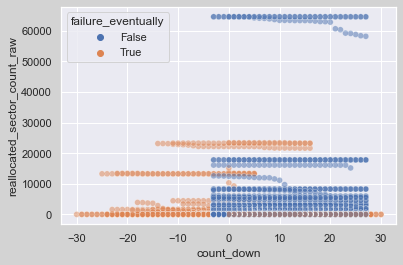

In [225]:
sns.scatterplot(data=df_hd_model, x="count_down", y="reallocated_sector_count_raw", hue="failure_eventually", alpha=0.5)

In [226]:
df_hd_model.describe().T

,count,mean,std,min,25%,50%,75%,max
failure,1701863.0,3.466789e-05,5.887844e-03,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
spin_up_time_raw,1701863.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
reallocated_sector_count_raw,1701863.0,1.187305e+01,5.371798e+02,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,6.463200e+04
seek_error_rate_raw,1701863.0,1.553001e+10,2.046827e+12,12.000000,4.031908e+08,5.982994e+08,7.823218e+08,2.814711e+14
power_on_time_raw,1701863.0,4.659424e+04,3.143310e+03,0.000000,4.458200e+04,4.634400e+04,4.862700e+04,5.756500e+04
reported_uncorrectable_error_raw,1701863.0,7.000681e-01,6.987016e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,6.040000e+02
command_timeout_count_raw,1701863.0,3.175873e-02,1.050281e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,8.200000e+01
current_pending_sector_count_raw,1701863.0,2.881191e+00,2.853225e+02,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.104000e+04
uncorrectable_sector_count_raw,1701863.0,2.881191e+00,2.853225e+02,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.104000e+04
capacity_gb,1701863.0,3.726023e+03,0.000000e+00,3726.023277,3.726023e+03,3.726023e+03,3.726023e+03,3.726023e+03


In [227]:
df_hd_model.query("failure_eventually == False").describe().T

,count,mean,std,min,25%,50%,75%,max
failure,1699204.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
spin_up_time_raw,1699204.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
reallocated_sector_count_raw,1699204.0,9.911125e+00,5.072809e+02,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,6.463200e+04
seek_error_rate_raw,1699204.0,1.554981e+10,2.048428e+12,12.000000,4.031857e+08,5.982055e+08,7.821939e+08,2.814711e+14
power_on_time_raw,1699204.0,4.659473e+04,3.144712e+03,0.000000,4.458200e+04,4.634300e+04,4.862900e+04,5.756500e+04
reported_uncorrectable_error_raw,1699204.0,6.725979e-01,6.858468e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,6.040000e+02
command_timeout_count_raw,1699204.0,3.153359e-02,1.050006e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,8.200000e+01
current_pending_sector_count_raw,1699204.0,2.846029e+00,2.855303e+02,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.104000e+04
uncorrectable_sector_count_raw,1699204.0,2.846029e+00,2.855303e+02,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.104000e+04
capacity_gb,1699204.0,3.726023e+03,0.000000e+00,3726.023277,3.726023e+03,3.726023e+03,3.726023e+03,3.726023e+03


In [ ]:
# randomly get some healthy hds for balancing the data
RSEED = 40
size_multiple_factor = 3
final_date = pd.Period(end_date) - 30
df_hd_model_healthy = df_hd_model.query("failure == 0 and date == @final_date")
df_hd_model_healthy = df_hd_model_healthy[~df_hd_model_healthy["serial_number"].isin(serial_failure)].sample(size_multiple_factor*len(df_hd_model_failure), random_state=RSEED)
df_hd_model_healthy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189 entries, 1718560 to 1722693
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   date                              189 non-null    object 
 1   serial_number                     189 non-null    object 
 2   model                             189 non-null    object 
 3   failure                           189 non-null    int64  
 4   spin_up_time_raw                  189 non-null    float64
 5   reallocated_sector_count_raw      189 non-null    float64
 6   seek_error_rate_raw               189 non-null    float64
 7   reported_uncorrectable_error_raw  189 non-null    float64
 8   command_timeout_count_raw         189 non-null    float64
 9   current_pending_sector_count_raw  189 non-null    float64
 10  uncorrectable_sector_count_raw    189 non-null    float64
 11  capacity_gb                       189 non-null    float64
dty

In [58]:
df_hd_model_cut = pd.concat([df_hd_model_failure, df_hd_model_healthy], ignore_index=True)
df_hd_model_cut.head()

,date,serial_number,model,failure,spin_up_time_raw,reallocated_sector_count_raw,seek_error_rate_raw,reported_uncorrectable_error_raw,command_timeout_count_raw,current_pending_sector_count_raw,uncorrectable_sector_count_raw,capacity_gb
0,2021-01-01,ZJV4MDYR,ST12000NM0007,1,0.0,33104.0,7.057052e+08,87.0,0.000000e+00,0.0,0.0,11176.0
1,2021-01-04,ZCH07WP7,ST12000NM0007,1,0.0,9173.0,4.298070e+09,870.0,0.000000e+00,0.0,0.0,11176.0
2,2021-01-04,ZCH0DG4W,ST12000NM0007,1,0.0,35080.0,6.666953e+08,300.0,0.000000e+00,0.0,0.0,11176.0
3,2021-01-05,ZJV4LWRR,ST12000NM0007,1,0.0,304.0,8.534049e+08,13.0,0.000000e+00,0.0,0.0,11176.0
4,2021-01-06,ZCH07HR7,ST12000NM0007,1,0.0,12800.0,4.677768e+08,53.0,4.295098e+09,584.0,584.0,11176.0


# Baseline Model using Daniela's Data

In [217]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, RocCurveDisplay, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, Normalizer

In [40]:
file_path = repository_directory + "data/" +"ST4000DM000_processed" 
print(file_path)
df_tmp = pd.read_csv(file_path)
df_tmp.head()

../data/ST4000DM000_processed


,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_normalized,smart_4_raw,...,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw,date_failure,countdown
0,2020-09-15,Z304KBK4,ST4000DM000,4000787030016,0,113.0,53991680.0,92.0,100.0,14.0,...,200.0,0.0,100.0,43260.0,100.0,5.936166e+10,100.0,3.123054e+11,2021-12-16,457.0
1,2020-09-15,Z304JGH0,ST4000DM000,4000787030016,0,111.0,31142392.0,91.0,100.0,13.0,...,200.0,0.0,100.0,42459.0,100.0,5.902419e+10,100.0,2.553616e+11,2021-01-14,121.0
2,2020-09-15,Z302SYHL,ST4000DM000,4000787030016,0,120.0,238681648.0,92.0,100.0,22.0,...,200.0,0.0,100.0,43769.0,100.0,6.132206e+10,100.0,2.526737e+11,2021-05-22,249.0
3,2020-09-15,S3010L7K,ST4000DM000,4000787030016,0,118.0,180888736.0,94.0,100.0,6.0,...,200.0,0.0,100.0,46589.0,100.0,6.335880e+10,100.0,2.237496e+11,2020-12-11,87.0
4,2020-09-15,Z304JM6A,ST4000DM000,4000787030016,0,114.0,59625576.0,92.0,100.0,16.0,...,200.0,0.0,100.0,43281.0,100.0,5.857410e+10,100.0,2.774035e+11,2021-01-24,131.0


In [41]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241870 entries, 0 to 241869
Data columns (total 52 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   date                  241870 non-null  object 
 1   serial_number         241870 non-null  object 
 2   model                 241870 non-null  object 
 3   capacity_bytes        241870 non-null  int64  
 4   failure               241870 non-null  int64  
 5   smart_1_normalized    241870 non-null  float64
 6   smart_1_raw           241870 non-null  float64
 7   smart_3_normalized    241870 non-null  float64
 8   smart_4_normalized    241870 non-null  float64
 9   smart_4_raw           241870 non-null  float64
 10  smart_5_normalized    241870 non-null  float64
 11  smart_5_raw           241870 non-null  float64
 12  smart_7_normalized    241870 non-null  float64
 13  smart_7_raw           241870 non-null  float64
 14  smart_9_normalized    241870 non-null  float64
 15  

In [42]:
df_tmp.nunique()

date                       730
serial_number              608
model                        1
capacity_bytes               1
failure                      2
smart_1_normalized          35
smart_1_raw             240510
smart_3_normalized           9
smart_4_normalized           1
smart_4_raw                 58
smart_5_normalized          50
smart_5_raw               1384
smart_7_normalized          36
smart_7_raw             241420
smart_9_normalized          43
smart_9_raw              24806
smart_10_normalized          1
smart_12_normalized          1
smart_12_raw                57
smart_183_normalized        99
smart_183_raw              313
smart_184_normalized        87
smart_184_raw              153
smart_187_normalized       100
smart_187_raw              526
smart_188_normalized         3
smart_188_raw               28
smart_189_normalized         2
smart_189_raw                2
smart_190_normalized        46
smart_190_raw               46
smart_191_normalized         1
smart_19

In [178]:
file_path = repository_directory + "data/" +"ST4000DM000_processed_relevant" 
print(file_path)
df_d = pd.read_csv(file_path, parse_dates=["date"])
df_d = keep_some_smart_column_for_dataframe(df_d, smart_to_keep=key_smart, raw_or_normalized="raw")
df_d.head(5)

../data/ST4000DM000_processed_relevant


,date,serial_number,model,failure,date_failure,countdown,smart_5_raw,smart_183_raw,smart_184_raw,smart_187_raw
0,2020-09-15,Z304KBK4,ST4000DM000,0,2021-12-16,457.0,0.0,0.0,0.0,0.0
1,2020-09-15,Z304JGH0,ST4000DM000,0,2021-01-14,121.0,0.0,0.0,0.0,0.0
2,2020-09-15,Z302SYHL,ST4000DM000,0,2021-05-22,249.0,0.0,4.0,0.0,33.0
3,2020-09-15,S3010L7K,ST4000DM000,0,2020-12-11,87.0,0.0,2.0,0.0,0.0
4,2020-09-15,Z304JM6A,ST4000DM000,0,2021-01-24,131.0,0.0,0.0,0.0,0.0
5,2020-09-15,Z304Y01F,ST4000DM000,0,2021-05-14,241.0,0.0,1.0,0.0,6.0
6,2020-09-15,S301GNE5,ST4000DM000,0,2021-09-11,361.0,0.0,2.0,0.0,6.0
7,2020-09-15,Z302AYQQ,ST4000DM000,0,2021-10-30,410.0,0.0,0.0,0.0,0.0
8,2020-09-15,Z305D5SL,ST4000DM000,0,2021-07-16,304.0,0.0,1.0,0.0,0.0
9,2020-09-15,Z304JCZ2,ST4000DM000,0,2021-02-25,163.0,0.0,0.0,0.0,0.0


In [179]:
df_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241870 entries, 0 to 241869
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date           241870 non-null  datetime64[ns]
 1   serial_number  241870 non-null  object        
 2   model          241870 non-null  object        
 3   failure        241870 non-null  int64         
 4   date_failure   241870 non-null  object        
 5   countdown      241870 non-null  float64       
 6   smart_5_raw    241870 non-null  float64       
 7   smart_183_raw  241870 non-null  float64       
 8   smart_184_raw  241870 non-null  float64       
 9   smart_187_raw  241870 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 18.5+ MB


In [180]:
df_d["failure"].value_counts()

0    241260
1       610
Name: failure, dtype: int64

## Train-Test Split

We will split the data according to serial numbers

In [256]:
RSEED = 200
serial_number_train, serial_number_test, dummy_train, dummy_test = train_test_split(df_d["serial_number"].unique(), df_d["serial_number"].unique(), test_size=0.2, random_state=RSEED)
serial_number_train = pd.Series(serial_number_train)
serial_number_test = pd.Series(serial_number_test)

df_d_train = df_d[ df_d["serial_number"].isin(serial_number_train)]
y_train = df_d_train["countdown"]
X_train = df_d_train.drop("countdown", axis=1)
df_d_test = df_d[ df_d["serial_number"].isin(serial_number_test)]
y_test = df_d_test["countdown"]
X_test = df_d_test.drop("countdown", axis=1)

print("number of failure observed in train:", df_d_train.query("failure == 1")["failure"].count(), "over",df_d_train.query("failure == False")["failure"].count())
print("number of failure observed in test:", df_d_test.query("failure == 1")["failure"].count(), "over",df_d_test.query("failure == 0")["failure"].count())

print("number of unique disk in data:", df_d["serial_number"].nunique())
print("number of unique disk in train:", df_d_train["serial_number"].nunique())
print("number of unique disk in test:", df_d_test["serial_number"].nunique())


number of failure observed in train: 488 over 194235
number of failure observed in test: 122 over 47025
number of unique disk in data: 608
number of unique disk in train: 486
number of unique disk in test: 122


<AxesSubplot:xlabel='countdown', ylabel='smart_5_raw'>

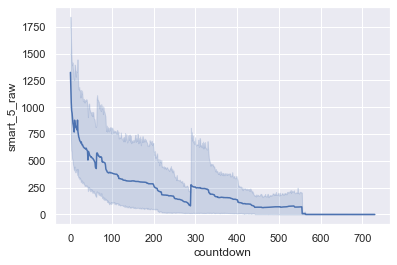

In [185]:
sns.lineplot(data=df_d_train, x="countdown", y="smart_5_raw", estimator="mean")

<AxesSubplot:xlabel='countdown', ylabel='smart_183_raw'>

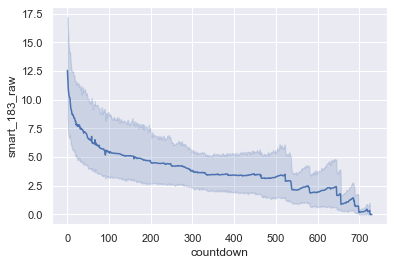

In [186]:
sns.lineplot(data=df_d_train, x="countdown", y="smart_183_raw", estimator="mean")

<AxesSubplot:xlabel='countdown', ylabel='smart_184_raw'>

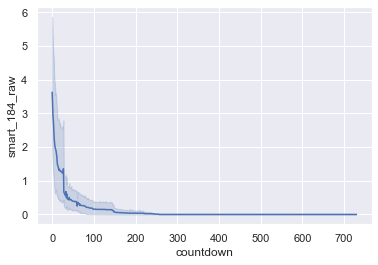

In [187]:
sns.lineplot(data=df_d_train, x="countdown", y="smart_184_raw", estimator="mean")

<AxesSubplot:xlabel='countdown', ylabel='smart_187_raw'>

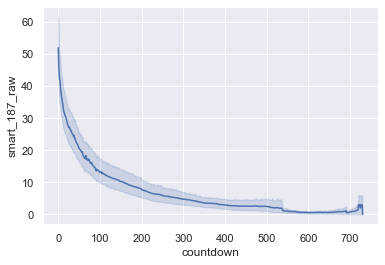

In [188]:
sns.lineplot(data=df_d_train, x="countdown", y="smart_187_raw", estimator="mean")

<AxesSubplot:xlabel='countdown', ylabel='smart_5_raw'>

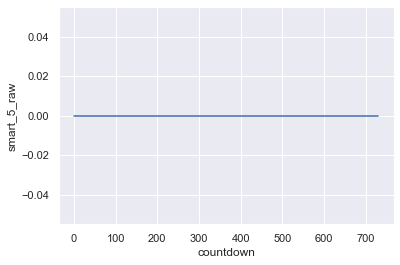

In [189]:
sns.lineplot(data=df_d_train, x="countdown", y="smart_5_raw", estimator=np.median)

<AxesSubplot:xlabel='countdown', ylabel='smart_183_raw'>

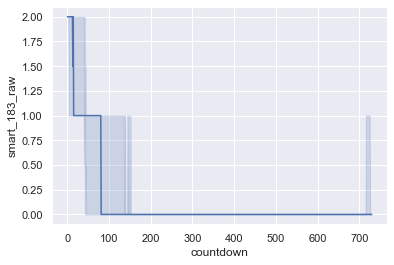

In [190]:
sns.lineplot(data=df_d_train, x="countdown", y="smart_183_raw", estimator=np.median)

<AxesSubplot:xlabel='countdown', ylabel='smart_184_raw'>

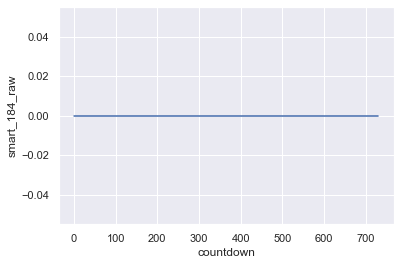

In [191]:
sns.lineplot(data=df_d_train, x="countdown", y="smart_184_raw", estimator=np.median)

<AxesSubplot:xlabel='countdown', ylabel='smart_187_raw'>

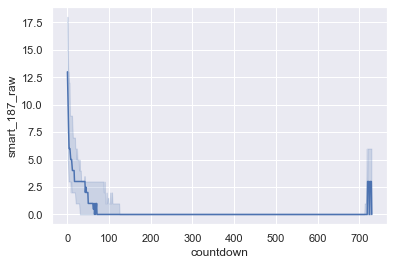

In [192]:
sns.lineplot(data=df_d_train, x="countdown", y="smart_187_raw", estimator=np.median)

## Baseline Model

In [247]:
def baseline_failure_prediction(features):
    s5r = features["smart_5_raw"]
    s183r = features["smart_183_raw"]
    s184r = features["smart_184_raw"]
    s187r = features["smart_187_raw"]
    #if s5r >= 1.0 and s183r >= 5 and s184r >= 1 and s187r >= 20:
    if s5r >= 1.0 or s183r >= 1 or s184r >= 1 or s187r >= 2:
        return True
    return False

days_before_failure = 30
def get_truth(features, days=days_before_failure):
    if features["countdown"] <= days:
        return True
    return False

transform y_train and y_test to classification results (True and False):

In [257]:

y_train_c = y_train.apply(lambda x : True if x <= days_before_failure else False)
y_test_c = y_test.apply(lambda x : True if x <= days_before_failure else False)

make predictions on train and test data:

In [258]:
y_train_c_pred = X_train.apply(baseline_failure_prediction, axis=1)
y_test_c_pred = X_test.apply(baseline_failure_prediction, axis=1)

print out confusion matrix, classification reports, and ROC-AUC score:

# Confusion matrix for train data(log10 scale):


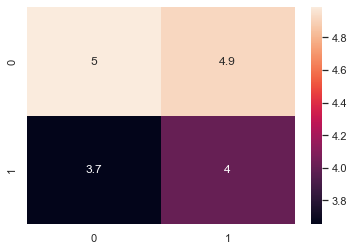

In [259]:
print("# Confusion matrix for train data(log10 scale):")
ax1 = sns.heatmap(np.log10(confusion_matrix(y_train_c, y_train_c_pred)), annot=True)

# Confusion matrix for test data(log10 scale):


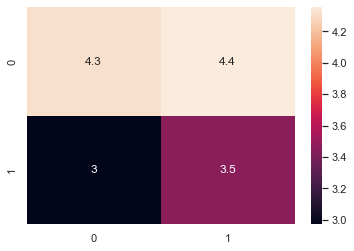

In [260]:
print("# Confusion matrix for test data(log10 scale):")
ax2 = sns.heatmap(np.log10(confusion_matrix(y_test_c, y_test_c_pred)), annot=True)

In [261]:
print("classification report for train data:")
print(classification_report(y_train_c, y_train_c_pred))
print("classification report for test data:")
print(classification_report(y_test_c, y_test_c_pred))


classification report for train data:
              precision    recall  f1-score   support

       False       0.96      0.54      0.69    180121
        True       0.11      0.69      0.19     14602

    accuracy                           0.55    194723
   macro avg       0.53      0.62      0.44    194723
weighted avg       0.89      0.55      0.65    194723

classification report for test data:
              precision    recall  f1-score   support

       False       0.96      0.48      0.64     43382
        True       0.11      0.75      0.19      3765

    accuracy                           0.50     47147
   macro avg       0.53      0.61      0.42     47147
weighted avg       0.89      0.50      0.60     47147



In [262]:
print("roc auc score for train:", roc_auc_score(y_train_c, y_train_c_pred).round(4))
print("roc auc score for test:", roc_auc_score(y_test_c, y_test_c_pred).round(4))

roc auc score for train: 0.6155
roc auc score for test: 0.6145


# Logistic Regression

We could observe the data and decide which scaler to use:

In [238]:
df_d_train.describe().T

,count,mean,std,min,25%,50%,75%,max
failure,192054.0,0.002541,0.050344,0.0,0.0,0.0,0.0,1.0
countdown,192054.0,255.067101,175.084146,0.0,107.0,229.0,383.0,730.0
smart_5_raw,192054.0,282.079748,2952.611605,0.0,0.0,0.0,0.0,65488.0
smart_183_raw,192054.0,4.686677,23.524723,0.0,0.0,0.0,2.0,590.0
smart_184_raw,192054.0,0.202896,4.455629,0.0,0.0,0.0,0.0,340.0
smart_187_raw,192054.0,9.764988,35.265549,0.0,0.0,0.0,6.0,714.0


It looks like a log transformation would be nice for all of the smart features.

In [265]:
X_train = df_d_train.iloc[:,2:6 ]

In [266]:
X_train

,model,failure,date_failure,countdown
0,ST4000DM000,0,2021-12-16,457.0
2,ST4000DM000,0,2021-05-22,249.0
3,ST4000DM000,0,2020-12-11,87.0
4,ST4000DM000,0,2021-01-24,131.0
5,ST4000DM000,0,2021-05-14,241.0
...,...,...,...,...
241865,ST4000DM000,0,2021-05-04,231.0
241866,ST4000DM000,0,2021-02-07,145.0
241867,ST4000DM000,0,2021-03-19,185.0
241868,ST4000DM000,0,2021-10-31,411.0


<AxesSubplot:xlabel='smart_5_raw', ylabel='Count'>

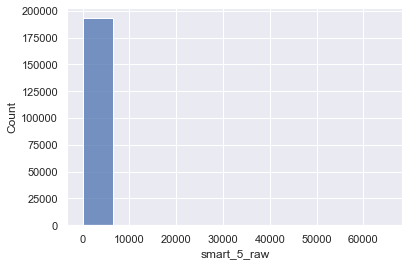

In [264]:
#sns.barplot(data=df_d_train, x="")
sns.histplot(data=df_d_train, x="smart_5_raw", bins=10)

In [ ]:
model_logistic_regression = LogisticRegression()
model_logistic_regression.fit = 

array([2, 1, 0])

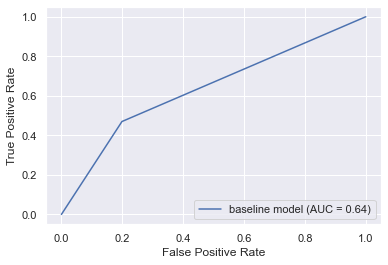

In [ ]:
sns.set(rc={'figure.facecolor': "white"})
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='baseline model')
display.plot()
plt.show()

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_pred)